# CSCI153 Final Project: Neural Style Transfer
## Stephanie Fulcar & Elena Williams

In this project, we are recrating the style transfer algorithm delveloped by [Gatys et. al.](https://arxiv.org/pdf/1508.06576)

## Setup

In [44]:
!pip install -r requirements.txt


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\sfulc\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
# Standard Libraries
import numpy as np

# Model Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim

import torchvision.transforms as transforms
import torchvision.models as models

import copy

# Visualization Libraries
from PIL import Image
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [16, 10] # matplotlib setting to control the size of display images

In [46]:
# Check to see if we're running on the server GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## DataLoader

In [47]:
# Defining image size based on harware capacity
# set imsize to 512 if working w/ GPU and 128 if working w/ CPU
imsize = 128

# Creating loader that formats all out images to be the correct size
loader = transforms.Compose([
    transforms.Resize([imsize, imsize]),
    transforms.ToTensor()
])

def image_loader(im_name):
    im = loader(Image.open(im_name)).unsqueeze(0)
    return im.to(device, torch.float)

The paper did not provide the image files they used, but I was able to find the Amsterdam photo on [Wikipedia](https://en.wikipedia.org/wiki/File:Tuebingen_Neckarfront.jpg) and Starry Night on [Wikimedia](https://commons.wikimedia.org/wiki/File:Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg). 

In [48]:
style_im = image_loader("images\Starry_Night.jpg")
content_im = image_loader("images\Tuebingen_Neckarfront.jpg")

In [49]:
# Function to convert model output back to image format
def tensor_to_image(tensor):
    image = transforms.ToPILImage()(tensor.cpu().clone().squeeze(0))
    return image

## Model Components: Loss Functions & Optimizer
The style transfer model attempts to minimize two different loss functions at the same time, one for content and one for style. The content loss function is simply a mean squared error loss while the style loss function applies a Gram matrix to the image prior to applying a mean squared error loss.

In [50]:
# Content Loss Function
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, im):
        self.loss = F.mse_loss(im, self.target)
        return im

In [51]:
# Gram Matrix Implementation
def gram(input):
    dims = input.size()
    features = input.reshape(dims[0]*dims[1], dims[2]*dims[3])

    product = torch.mm(features, features.t())  # compute the gram product
    return product / (dims[0]*dims[1]*dims[2]*dims[3])

In [52]:
# Style Loss Function
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram(target_feature).detach()

    def forward(self, input):
        G = gram(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In the paper, the authors suggest using L-BFGS for the optimizer, so we use the Pytorch implementation here.

In [53]:
def get_optimizer(input_img):
    return optim.LBFGS([input_img.requires_grad_()])

## Model Setup

The paper builds their style transfer model on the VGG-19 architecture. The model documentation requires that we apply both a mean and a standard deviation normalization to the tensor inputs, so we include a normalization layer below.

In [54]:
network = models.vgg19(pretrained=True).features.to(device).eval()

In [55]:
norm_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
norm_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).reshape(-1, 1, 1)
        self.std = torch.tensor(std).reshape(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

## Building Our Model

The paper identified the specific layers that correspond to the content and style representations. Those layers are listed below. We use those layers from VGG to build our style transfer model.

In [56]:
content_layers = ['conv_4']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

In [57]:
def get_style_and_content_losses(network, norm_mean, norm_std,
                               style_img, content_img,
                               content_layers=content_layers,
                               style_layers=style_layers):
    network = copy.deepcopy(network)

    # normalization module
    normalization = Normalization(norm_mean, norm_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    layerNames = {
        nn.Conv2d: "conv",
        nn.ReLU: "relu",
        nn.MaxPool2d: "pool",
        nn.BatchNorm2d: "bn"
    }

    i = 0 # increment every time we see a conv
    for layer in network.children():
        for layerType in layerNames.keys():
            if isinstance(layer, layerType):
                name = layerNames[layerType] + "_" + str(i)
                if layerType == nn.Conv2d:
                    i += 1
                elif layerType == nn.ReLU:
                    layer = nn.ReLU(inplace=False)
        
        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

In [58]:
def run_style_transfer(network, norm_mean, norm_std, content_img, style_img,
                        input_img, num_steps=300, disp_count=50, style_layers=style_layers,
                        content_layers=content_layers, style_weight=1000000, content_weight=2):
    
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_and_content_losses(network,
        norm_mean, norm_std, style_img, content_img,
        content_layers=content_layers, style_layers=style_layers)
    
    optimizer = get_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:
        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                disp_img = tensor_to_image(input_img)
                # CHANGED!
                plt.subplot(int(num_steps/(2*disp_count)+1),2,int(run[0]/disp_count))
                plt.imshow(disp_img)
                plt.figsize=(12,8)
                plt.title('Step ' + str(run[0]) + ' Loss = ({:4f}'.format(style_score.item()) + ',{:4f})'.format(content_score.item()))
                plt.axis('off')
            return style_score + content_score

        optimizer.step(closure)
    
    
    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

## Testing Model On Different Artisitic Styles


### Style Image = Starry Night

(-0.5, 127.5, 127.5, -0.5)

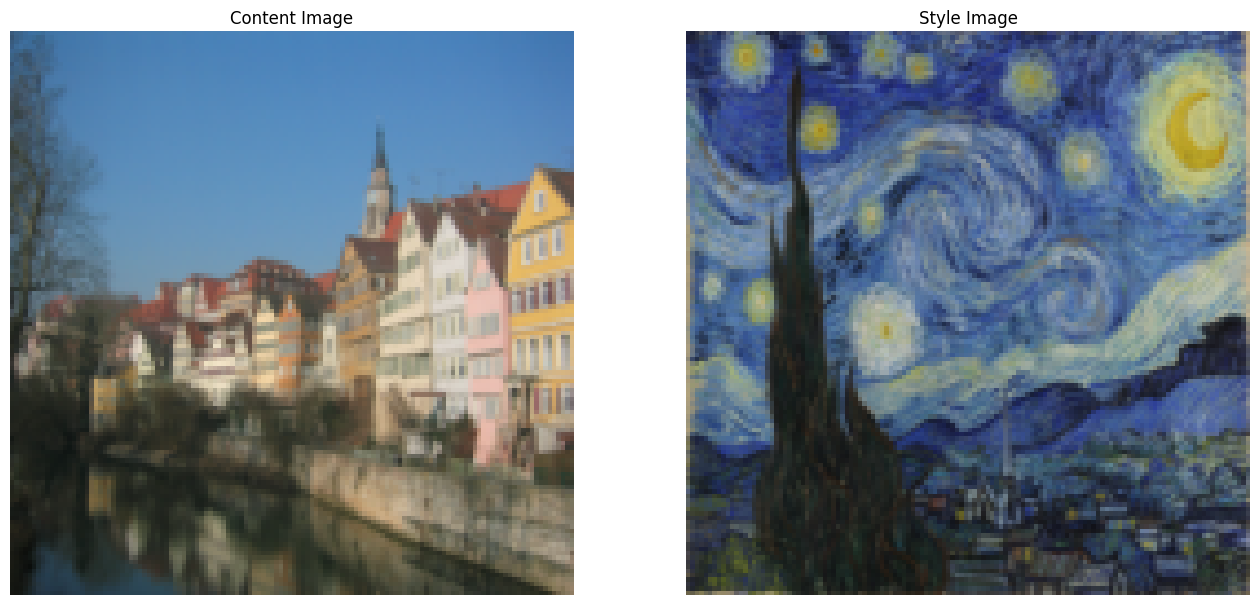

In [59]:
content_tensor = image_loader("images/Tuebingen_Neckarfront.jpg")
style_tensor = image_loader("images/Starry_Night.jpg")

content_img = tensor_to_image(content_tensor)
style_img = tensor_to_image(style_tensor)

input_tensor = content_tensor.clone()

plt.subplot(1,2,1)
plt.imshow(content_img)
plt.title('Content Image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(style_img)
plt.title('Style Image')
plt.axis('off')

Building the style transfer model..


C:\Users\sfulc\AppData\Local\Temp\ipykernel_68504\3671226623.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).reshape(-1, 1, 1)
C:\Users\sfulc\AppData\Local\Temp\ipykernel_68504\3671226623.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).reshape(-1, 1, 1)


Optimizing..


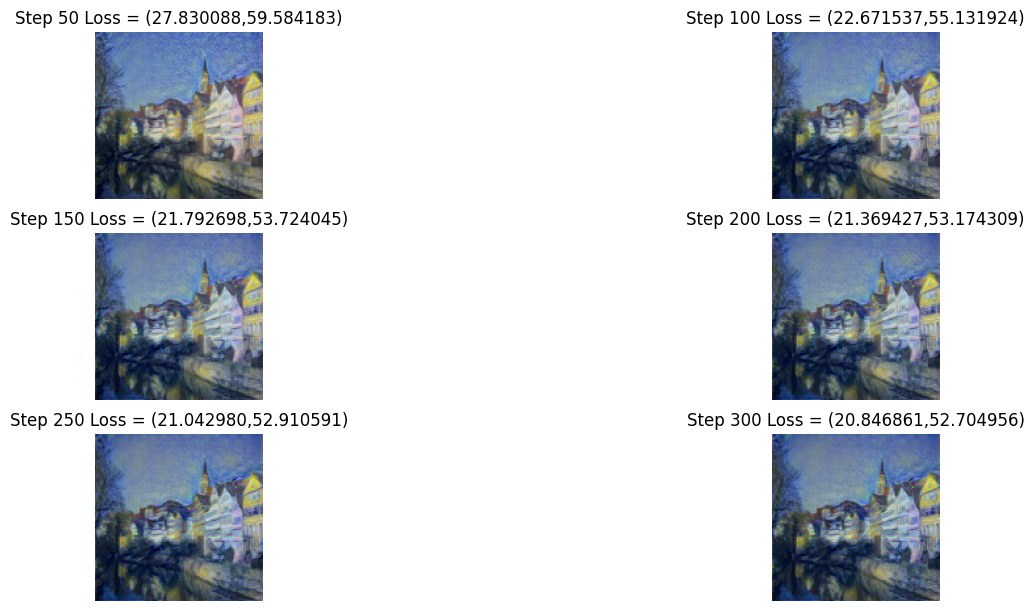

In [ ]:
num_steps = 300
disp_count = 50
output = run_style_transfer(network, norm_mean, norm_std, content_tensor, style_tensor,
                           input_tensor, num_steps=num_steps, disp_count=disp_count, style_layers=style_layers,
                           content_layers=content_layers, style_weight=100000, content_weight=2)

(-0.5, 127.5, 127.5, -0.5)

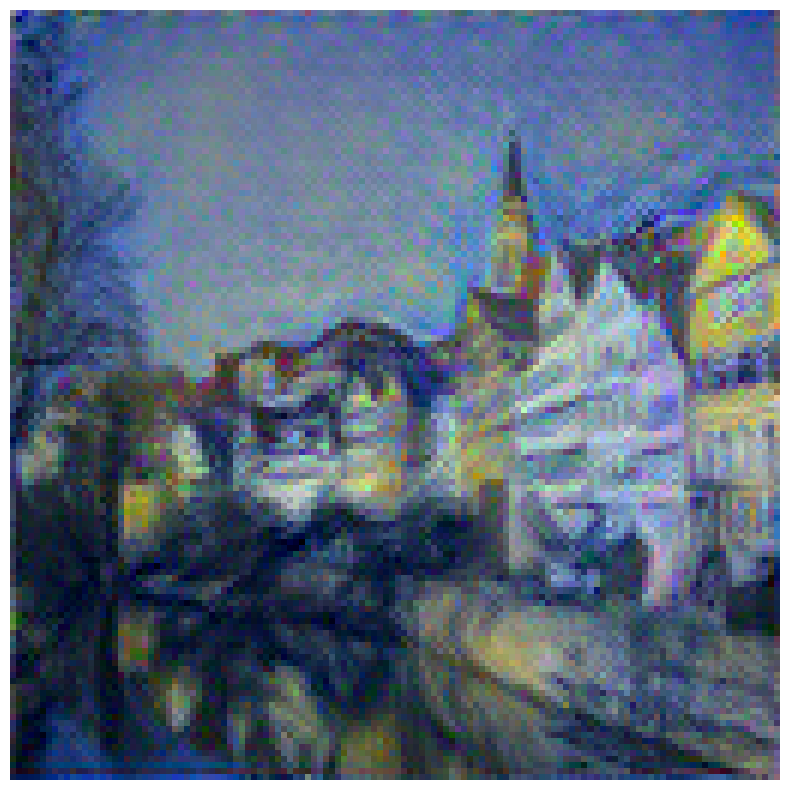

In [63]:
plt.imshow(tensor_to_image(output))
plt.axis('off')

### Style Image = Picasso

(-0.5, 127.5, 127.5, -0.5)

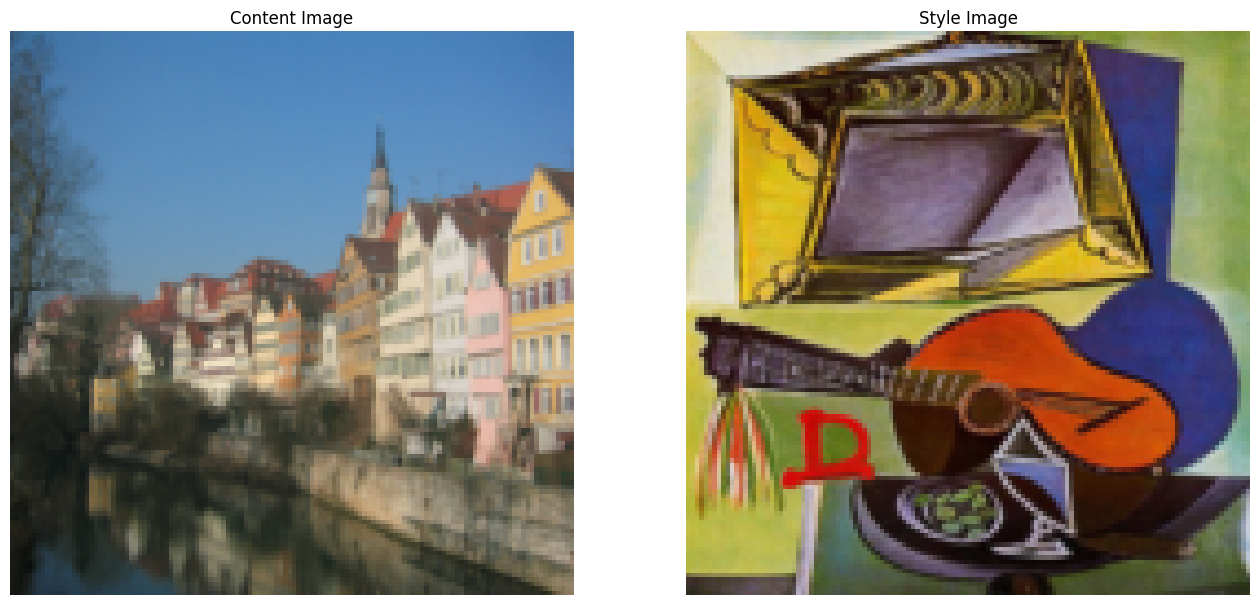

In [64]:
content_tensor = image_loader("images/Tuebingen_Neckarfront.jpg")
style_tensor = image_loader("images/picasso.jpg")

content_img = tensor_to_image(content_tensor)
style_img = tensor_to_image(style_tensor)

input_tensor = content_tensor.clone()

plt.subplot(1,2,1)
plt.imshow(content_img)
plt.title('Content Image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(style_img)
plt.title('Style Image')
plt.axis('off')

Building the style transfer model..


C:\Users\sfulc\AppData\Local\Temp\ipykernel_68504\3671226623.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).reshape(-1, 1, 1)
C:\Users\sfulc\AppData\Local\Temp\ipykernel_68504\3671226623.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).reshape(-1, 1, 1)


Optimizing..


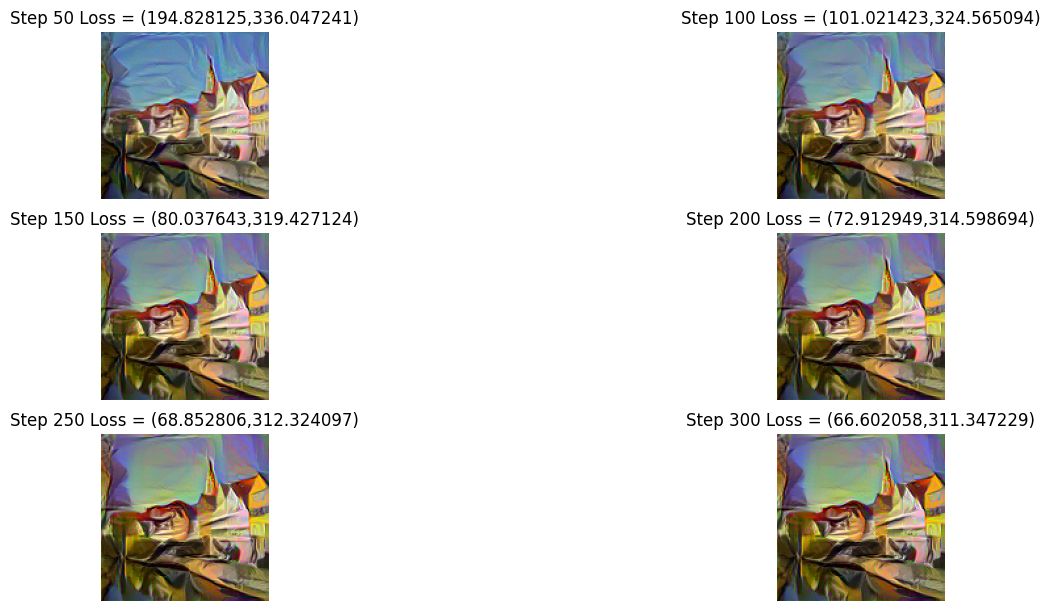

In [65]:
num_steps = 300
disp_count = 50
output = run_style_transfer(network, norm_mean, norm_std, content_tensor, style_tensor,
                           input_tensor, num_steps=num_steps, disp_count=disp_count, style_layers=style_layers,
                           content_layers=content_layers, style_weight=100000, content_weight=2)

(-0.5, 127.5, 127.5, -0.5)

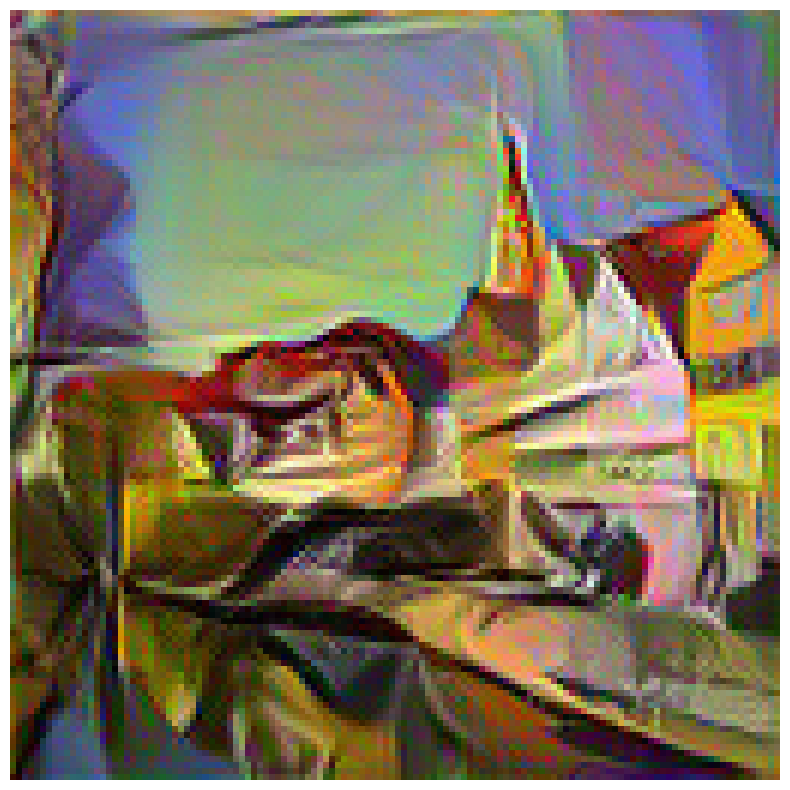

In [66]:
plt.imshow(tensor_to_image(output))
plt.axis('off')

### Style Image = Pollock

(-0.5, 127.5, 127.5, -0.5)

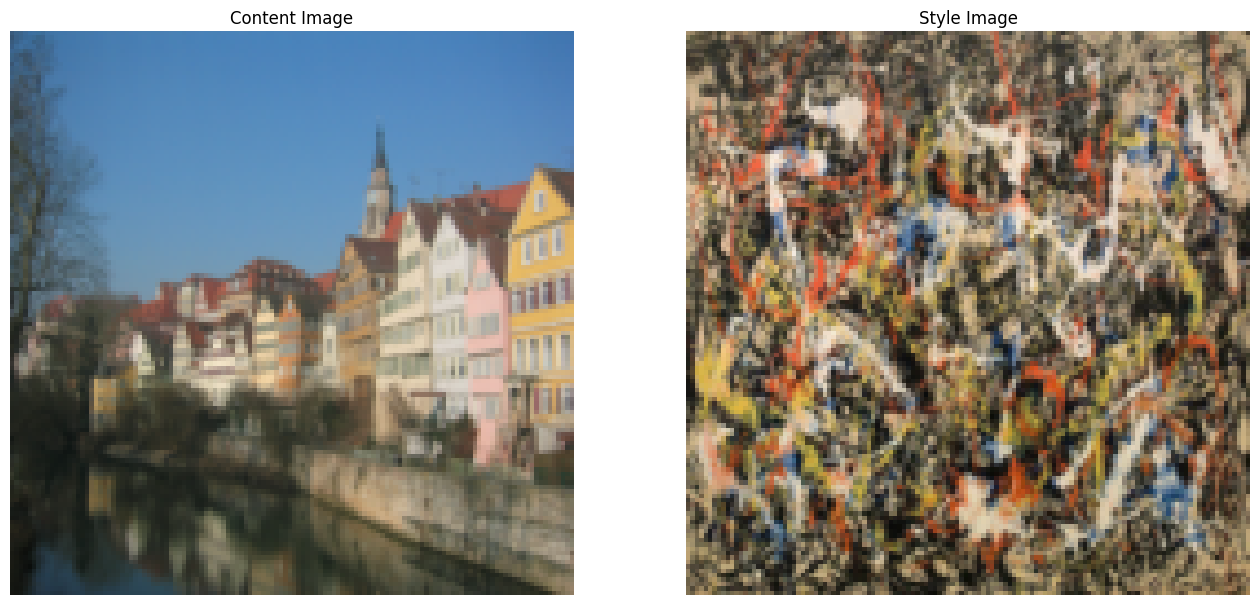

In [67]:
content_tensor = image_loader("images/Tuebingen_Neckarfront.jpg")
style_tensor = image_loader("images/pollock.jpg")

content_img = tensor_to_image(content_tensor)
style_img = tensor_to_image(style_tensor)

input_tensor = content_tensor.clone()

plt.subplot(1,2,1)
plt.imshow(content_img)
plt.title('Content Image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(style_img)
plt.title('Style Image')
plt.axis('off')

Building the style transfer model..


C:\Users\sfulc\AppData\Local\Temp\ipykernel_68504\3671226623.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).reshape(-1, 1, 1)
C:\Users\sfulc\AppData\Local\Temp\ipykernel_68504\3671226623.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).reshape(-1, 1, 1)


Optimizing..


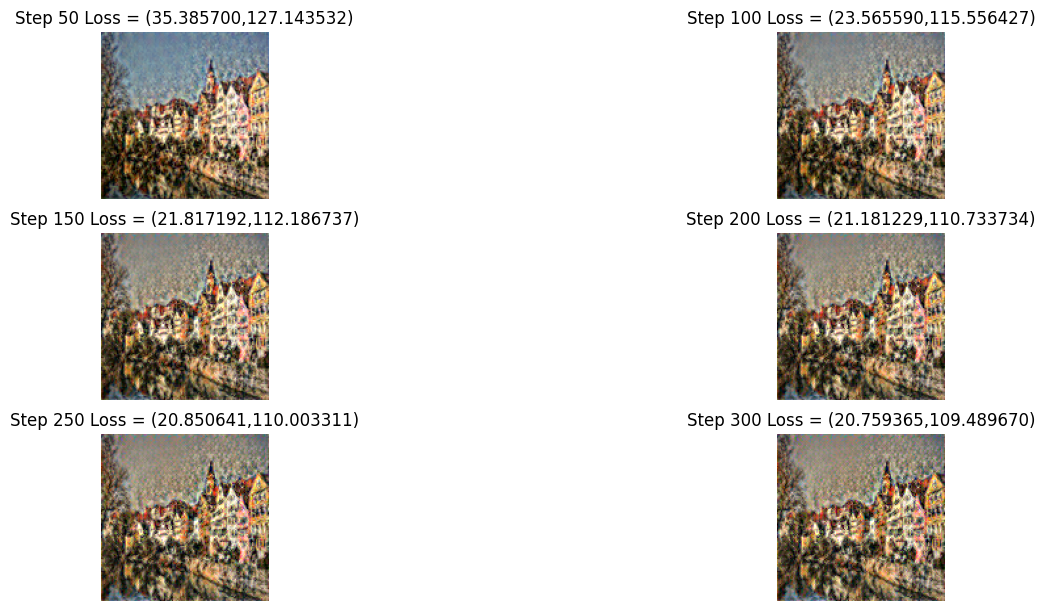

In [68]:
num_steps = 300
disp_count = 50
output = run_style_transfer(network, norm_mean, norm_std, content_tensor, style_tensor,
                           input_tensor, num_steps=num_steps, disp_count=disp_count, style_layers=style_layers,
                           content_layers=content_layers, style_weight=100000, content_weight=2)

(-0.5, 127.5, 127.5, -0.5)

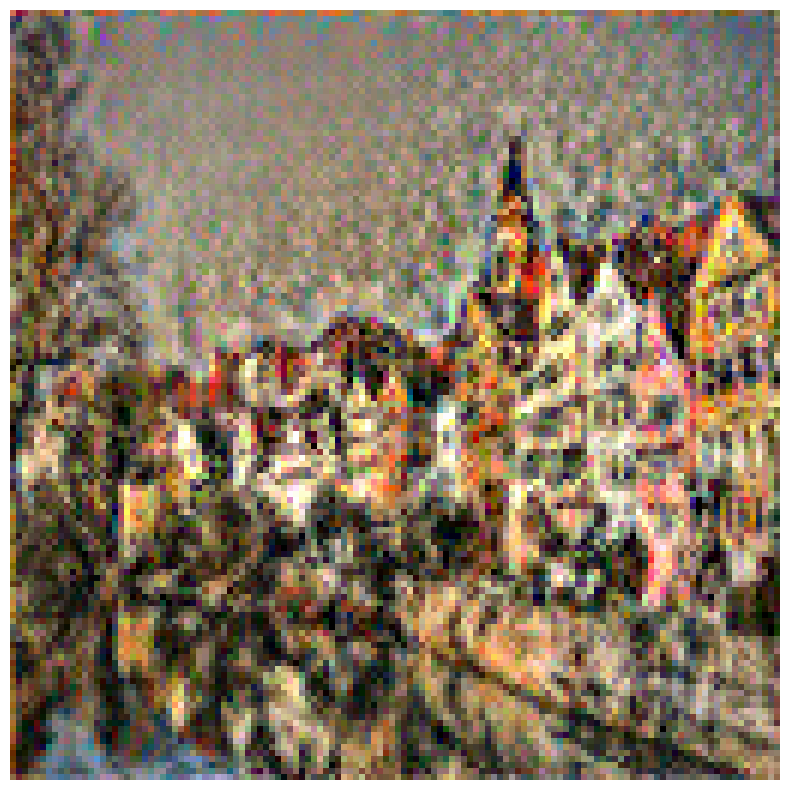

In [69]:
plt.imshow(tensor_to_image(output))
plt.axis('off')